<a href="https://www.kaggle.com/code/scottfredschmidt/housepricepredict?scriptVersionId=96696431" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predict House Prices
Data has 79 explanatory variables describing aspects of residential homes in Ames, Iowa. Prediction modeling resulted in the following starting with the highest r-squared:
* Decision tree is 0.9836
* Gradient booster classification 0.899 with a deviation of 0.031. 
* Random forest 0.8905. 
* Linear regression 0.8002 
* KNN: Slow runtime
* SVM: Bad Results

Even though the decision tree delivers the best r-squared, random forest and gradient boost are the better predictive models because they do not overfit the data. 

# Datasets
* Train.csv: This is the most important dataset that will be split to find patterns and predictions. 
*  Test.Csv: A final dollar price prediction will be made for all of the 1460 homes on the test data.  

# Train Data
The original dataset with no adjustments will be shown below. The data is in the shape of rows 1459 and 80 columns.  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from statistics import mean
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.datasets import make_classification
from sklearn import ensemble
import sklearn.metrics as metrics
import time
 
train=r'/kaggle/input/house-prices-advanced-regression-techniques/train.csv' 
test=r'/kaggle/input/house-prices-advanced-regression-techniques/test.csv'

data=pd.read_csv(train)  #(1459, 80) 
testDF=pd.read_csv(test)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [3]:
data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [4]:
#Check Duplicates:
dupstr = data.duplicated()
dup2 = testDF.duplicated()
print('Total no of duplicate values in Training Dataset = %d' % (dupstr.sum()))
print('Total no of duplicate values in Test Dataset = %d' % (dup2.sum()))
#data[dupstr]

Total no of duplicate values in Training Dataset = 0
Total no of duplicate values in Test Dataset = 0


# Outliers 
Removing sales price outliers for houses above half a million dollars, improved the final score by around .01%. 

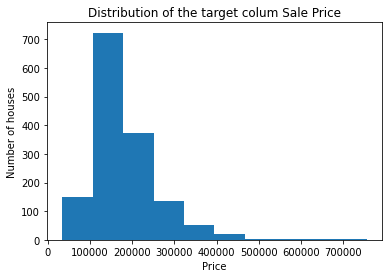

In [5]:
plt.hist(data.SalePrice)
plt.title('Distribution of the target colum Sale Price')
plt.xlabel('Price')
plt.ylabel('Number of houses')
plt.show()

In [6]:
outliers_price = data[data.SalePrice > 500_000].index
data= data.drop(outliers_price)

# Categorical Variables
What categorical variablles seem valuable and practical enough to be changed into numeric variables? 

In [7]:
object_columns=data.select_dtypes(include='object').columns
for col in object_columns:
    pass
    #print(col)
    #print(data[col].value_counts())

# Feature Engineering
For now, only numeric categorical values will be analyzed. Certain columns must be combined into one. For example, total square feet is a new column combined from three other columns. Since every house needs a dollar prediction price, one must not delete any rows. Therefore, any missing data will be filled in the mean. 

In [8]:
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'].drop(columns=['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])
data['Condition1']=data['Condition1'].apply(lambda x:1 if x == 'Norm' else 0)
data['Condition2']=data['Condition2'].apply(lambda x:1 if x == 'Norm' else 0)
data['CentralAir'] = data['CentralAir'].replace({'Y':0, 'N':1})
data['SaleCondition']=data['SaleCondition'].apply(lambda x:5 if x == 'Normal' else 0)
data['Street']=data['Street'].fillna(0).apply(lambda x:0 if x =='Grvl' else 1)
data['MiscFeature']=data['MiscFeature'].fillna(0).apply(lambda x:0 if x == 0 else 1)
data['HeatingQC']=data['HeatingQC'].apply(lambda x:1 if x == 'Ex' else 0)
data['Fence']=data['Fence'].fillna(0).apply(lambda x:0 if x == 0 else 1)
data['GarageFinish']=data['GarageFinish'].apply(lambda x:0 if x == 'Unf' else 1)

# New Encoded DataFrame

In [9]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF
0,1,60,RL,65.0,8450,1,NaN,Reg,Lvl,AllPub,...,NaN,0,0,0,2,2008,WD,5,208500,2566
1,2,20,RL,80.0,9600,1,NaN,Reg,Lvl,AllPub,...,NaN,0,0,0,5,2007,WD,5,181500,2524
2,3,60,RL,68.0,11250,1,NaN,IR1,Lvl,AllPub,...,NaN,0,0,0,9,2008,WD,5,223500,2706
3,4,70,RL,60.0,9550,1,NaN,IR1,Lvl,AllPub,...,NaN,0,0,0,2,2006,WD,0,140000,2473
4,5,60,RL,84.0,14260,1,NaN,IR1,Lvl,AllPub,...,NaN,0,0,0,12,2008,WD,5,250000,3343


# Numeric DataFrame
For now, we can analyze data by only having the number variables and not categorical values. Later on, we can encode categorical values to numeric values and see if there are any categorical values that may have high importance. 

In [10]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = data.select_dtypes(include=numerics)
df.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,...,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,TotalSF
0,1,60,65.0,8450,1,1,1,7,5,2003,...,0,0,0,0,0,2,2008,5,208500,2566
1,2,20,80.0,9600,1,0,1,6,8,1976,...,0,0,0,0,0,5,2007,5,181500,2524
2,3,60,68.0,11250,1,1,1,7,5,2001,...,0,0,0,0,0,9,2008,5,223500,2706
3,4,70,60.0,9550,1,1,1,7,5,1915,...,0,0,0,0,0,2,2006,0,140000,2473
4,5,60,84.0,14260,1,1,1,8,5,2000,...,0,0,0,0,0,12,2008,5,250000,3343


# Find Missing Values
First, missing data needs to be checked. Too many missing data points will get a column removed. An initial DataFrame with numeric values is analyzed. Some categorical values will be assigned a numeric value to analyze for better results. Deleting rows would be a bad idea since we need all rows to predict every house price. Therefore, any column with lots of missing data will be removed. If a column has high feature importance, filling in the missing data with the mean can be considered. Since a prediction is needed for every house price, one cannot simply remove rows of data.

In [11]:
#search for columns with missing values:
def findNA():
    print("Missing data by column as a percent:")
    findNA=df.isnull().sum().sort_values(ascending=False)/len(data)
    print(findNA.head(4))
findNA() 

Missing data by column as a percent:
LotFrontage    0.178498
GarageYrBlt    0.055824
MasVnrArea     0.005513
Id             0.000000
dtype: float64


# Fix Missing Values

In [12]:
number=100 #remove col with  or more missing values
df = df[df.isnull().sum(axis=1) <= number] 
df= df.fillna(df.mean())
df.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,...,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleCondition,SalePrice,TotalSF
0,1,60,65.0,8450,1,1,1,7,5,2003,...,0,0,0,0,0,2,2008,5,208500,2566
1,2,20,80.0,9600,1,0,1,6,8,1976,...,0,0,0,0,0,5,2007,5,181500,2524
2,3,60,68.0,11250,1,1,1,7,5,2001,...,0,0,0,0,0,9,2008,5,223500,2706
3,4,70,60.0,9550,1,1,1,7,5,1915,...,0,0,0,0,0,2,2006,0,140000,2473
4,5,60,84.0,14260,1,1,1,8,5,2000,...,0,0,0,0,0,12,2008,5,250000,3343


# Heatmap
Using a visual heatmap can display all correlations between features and detect multicollinearity. The top ten correlations to SalesPrice will be shown below.

AxesSubplot(0.125,0.125;0.62x0.755)
Top ten correlations to sales price are: 
SalePrice      1.000000
OverallQual    0.802424
TotalSF        0.765506
GrLivArea      0.686872
GarageCars     0.654418
GarageArea     0.633607
TotalBsmtSF    0.596771
1stFlrSF       0.589676
FullBath       0.553014
YearBuilt      0.543898
Name: SalePrice, dtype: float64


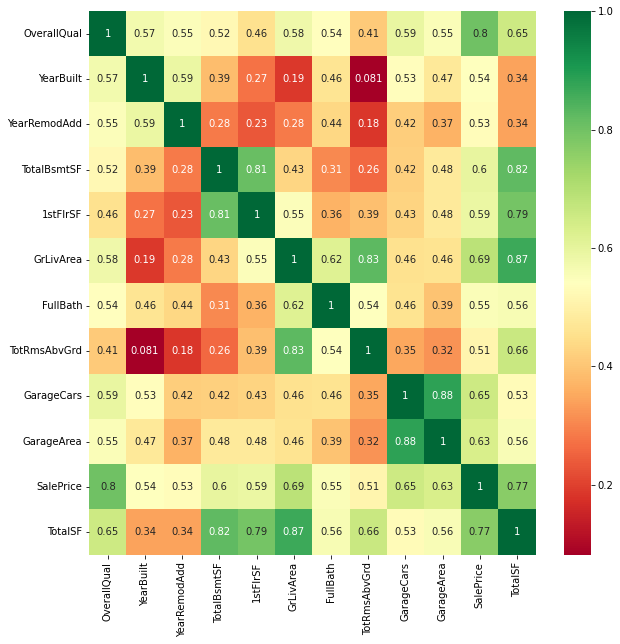

In [13]:
def printHeat():
    corr = df.corr()
    #print(corr)
    highly_corr_features = corr.index[abs(corr["SalePrice"])>0.5]
    plt.figure(figsize=(10,10))
    heat = sns.heatmap(df[highly_corr_features].corr(),annot=True,cmap="RdYlGn")
    top10=corr["SalePrice"].sort_values(ascending=False).head(10)
    print(heat)
    print("Top ten correlations to sales price are: ")
    print(top10) # top ten correlations
printHeat() 

# Highly Correlated Features
No major multicollinearity was detected other than first floor and basement floor with a .82 correlation. The square feet features were all combined into total square feet of the entire house so the basement feature no longer exists anyway.

In [14]:
def printHighCorr(df, features, threshold=0.8):
    print("Highly correlated variables above: ", threshold)
    corr_df = df[features].corr() # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    correlation_df={}
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            correlation_df[corr_df.index[i] +" and "+ corr_df.columns[j]]= v
        correlation_df=pd.DataFrame(correlation_df,index=['Correlation'])
    return  correlation_df.T.sort_values(by='Correlation',ascending=False)

printHighCorr(data,data.columns).style.set_properties(**{'background-color': 'black','color': 'white'})

Highly correlated variables above:  0.8


,Correlation
GarageCars and GarageArea,0.881573
GrLivArea and TotalSF,0.866235
GrLivArea and TotRmsAbvGrd,0.825282
YearBuilt and GarageYrBlt,0.824447
TotalBsmtSF and TotalSF,0.821175
TotalBsmtSF and 1stFlrSF,0.811904
OverallQual and SalePrice,0.802424


#### Drop Highly Correlated Featured

In [15]:
df=df.drop(['GarageArea', 'GarageYrBlt', 'GrLivArea'], axis=1)

## Total Square Feet Outlier

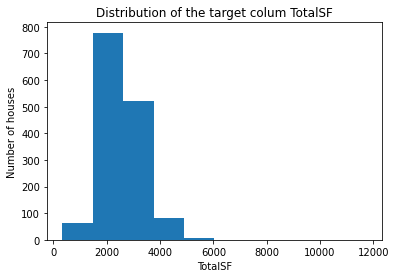

In [16]:
plt.hist(data.TotalSF)
plt.title('Distribution of the target colum TotalSF')
plt.xlabel('TotalSF')
plt.ylabel('Number of houses')
plt.show()

In [17]:
outliers_TotalSF = df[df.TotalSF > 5000].index
df= df.drop(outliers_TotalSF)

# Scatterplot Data
The most important features that were found with the highest correlation to house sales price which were the following: 'OverallQual','TotalBsmtSF','MSSubClass', 'LotArea'. This helps visually see the extent of correlations between the quantities and variables.

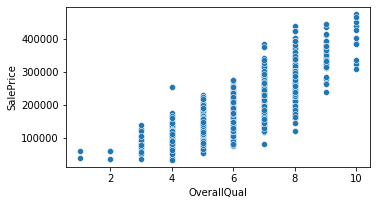

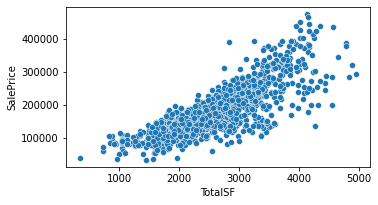

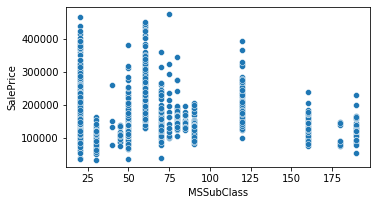

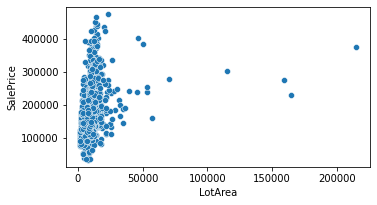

In [18]:
def pltFigure():
    names=['OverallQual','TotalSF','MSSubClass', 'LotArea']
    for name in names:
        fig = plt.figure(figsize=(12,10))
        plt.subplot(321)
        sns.scatterplot(data=df, x=name, y="SalePrice")
        plt.show()
pltFigure()

# Split Data 
SalesPrice will always be Y since it is the independent variable which is what we are analyzing. Split the data set into training data and test data. Split the data set into training and test data. 

In [19]:
X=df.drop('SalePrice', axis=1)
y=df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=13)

# Gradient Boost
* max_depth of 3 provides the highest r-squared with the least amount of error
* n_estimators of 500 provides the highest r-squared with the least amount of error
* The best min_samples_split is 2

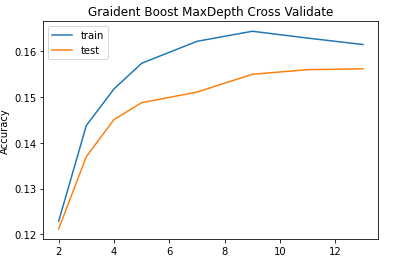

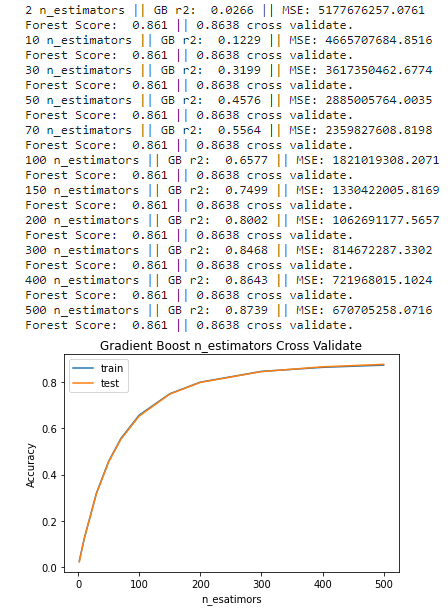

#### staring max_depth calculations:
* 2  max_depth || GB reg r2:  0.1214 || MSE: 4398122949.2849
* 3  max_depth || GB reg r2:  0.1347 || MSE: 4331400336.5671
* 4  max_depth || GB reg r2:  0.1413 || MSE: 4298427556.6608
* 5  max_depth || GB reg r2:  0.1474 || MSE: 4268005528.4897
* 7  max_depth || GB reg r2:  0.1506 || MSE: 4251927474.2259

#### starting GB n_estimators calculations:
* 2 n_estimators || GB regression r2:  0.0211 || MSE: 4900208368.3706
* 50 n_estimators || GB regression r2:  0.4531 || MSE: 2737693633.5497
* 100 n_estimators || GB regression r2:  0.6411 || MSE: 1796803824.8740
* 200 n_estimators || GB regression r2:  0.7731 || MSE: 1135655076.3048
* 300 n_estimators || GB regression r2:  0.8047 || MSE: 977465639.5303
* 400 n_estimators || GB regression r2:  0.8151 || MSE: 925412904.2621
* 500 n_estimators || GB regression r2:  0.8155 || MSE: 923406437.1715

In [20]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

def gbDepth():
    depthList=[2, 3, 4, 5, 7, 9, 11, 13]
    accList=[]
    cvList=[]
    
    for d in depthList:
        params = {
         "n_estimators": 10, "max_depth": d, 
            "min_samples_split": 5, "learning_rate": 0.01,
        }

        #Fit and Predict:
        gb = ensemble.GradientBoostingRegressor(**params)
        gb.fit(X_train, y_train)
        y_pred = gb.predict(X_test)
        
        gbR2 = r2_score(y_test, y_pred).round(4) 
        mse = mean_squared_error(y_test, gb.predict(X_test))
        print(d, " max_depth || GB reg r2: ", gbR2, "|| MSE: {:.4f}".format(mse)) 
        
        gbScore = gb.score(X_test, y_test).round(4)  # train test 
        gbCV = cross_validate(gb, X, y, cv = 5, scoring= 'r2')
        gbCV=gbCV['test_score'].mean().round(4)
        
        cvList.append(gbCV)
        accList.append(gbScore)
        
    plt.plot(depthList,accList, label="train")
    plt.plot(depthList,cvList, label="test")
    plt.title('Graident Boost MaxDepth Cross Validate')
    plt.xlabel('MaxDepth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 

def gbN():
    nList=[2, 10, 30, 50, 70, 100, 150, 200, 300, 400, 500]
    accList=[]
    cvList=[]
    for n in nList:
        params = {
         "n_estimators": n, "max_depth": 2, 
            "min_samples_split": 2, "learning_rate": 0.01,
        }

        #Fit and Predict:
        gb = ensemble.GradientBoostingRegressor(**params)
        gb.fit(X_train, y_train)
        y_pred = gb.predict(X_test)
        
        gbR2 = r2_score(y_test, y_pred).round(4) 
        mse = mean_squared_error(y_test, gb.predict(X_test))
        print(n, "n_estimators || GB r2: ", gbR2, "|| MSE: {:.4f}".format(mse)) 
        
        gbScore = gb.score(X_test, y_test).round(4)  # train test 
        gbCV = cross_validate(gb, X, y, cv = 4, scoring= 'r2')
        gbCV=gbCV['test_score'].mean().round(4)
        print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")
        
        accList.append(gbScore)
        cvList.append(gbCV)
    
    plt.plot(nList,accList, label="train")
    plt.plot(nList,cvList, label="test")
    plt.title('Gradient Boost n_estimators Cross Validate')
    plt.xlabel('n_esatimors')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 
    
def gbSplit():
    sList=[2, 3, 5, 7]
    
    for s in sList:
        params = {
         "n_estimators": 500, "max_depth": 2,
            "min_samples_split": s, "learning_rate": 0.01,
        }

        #Fit and Predict:
        reg = ensemble.GradientBoostingRegressor(**params)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        gbr_r2 = r2_score(y_test, y_pred).round(4)
        mse = mean_squared_error(y_test, reg.predict(X_test)).round(4)
        print(s," min_samples_splits || R2 ", gbr_r2, " || MSE {:.4f}".format(mse))

#Turn on or off functions here:
#gbDepth()
#gbN()
#gbSplit()

Gradient boosting regression r2:  0.776
The mean squared error (MSE) on test set: 1077377865.9262


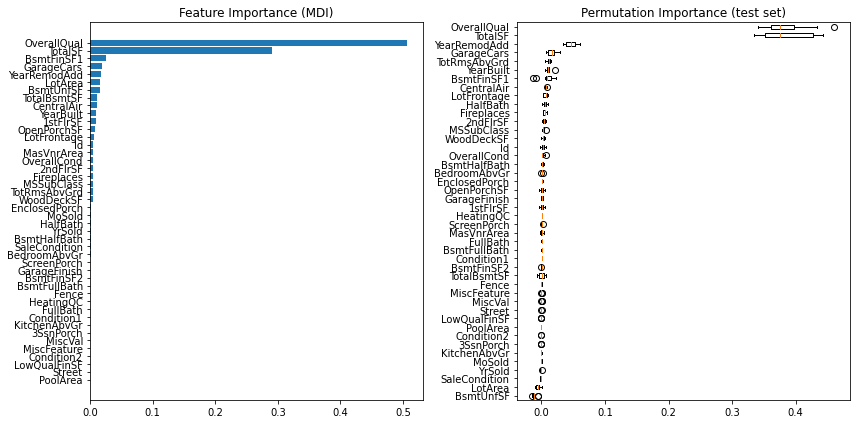

In [21]:
params = {
 "n_estimators": 200, "max_depth": 13, 
    "min_samples_split": 2, "learning_rate": 0.01,
}

gb= ensemble.GradientBoostingRegressor(**params)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
gbr_r2 = r2_score(y_test, y_pred).round(4) 
print("Gradient boosting regression r2: ", gbr_r2) 

mse = mean_squared_error(y_test, gb.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

#FEATURE IMPORTANCE:
cols=X.columns
feature_importance = gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(cols)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Linear Regression
R-squared and accuracy produced a 0.7979 performance result:
* The linear regression cross validated is 0.7785.
* Both ridge and lasso regression r-squared result is 0.7785.

Linear regression r2 score:  0.8728
Linear Accuracy:  0.8728
0.8664  linear regression cross validate mean
24737.14105856834  linear regression square error


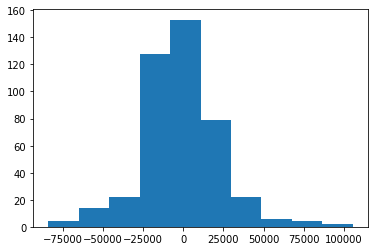

In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

#Fit and predict:
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)
lrPredict = lrModel.predict(X_test)

# plt.scatter(y_test, predictions)
plt.hist(y_test - lrPredict)

r2 = r2_score(y_test, lrPredict).round(4) 
print("Linear regression r2 score: ", r2)

#CROSS VALIDATE TEST RESULTS:
lr_score = lrModel.score(X_test, y_test).round(4)  # train test 
print("Linear Accuracy: ", lr_score)
lr_cv = cross_validate(lrModel, X, y, cv = 5, scoring= 'r2')
lr_cvMean=lr_cv['test_score'].mean().round(4)
print(lr_cvMean, " linear regression cross validate mean")

lrMSE=np.sqrt(metrics.mean_squared_error(y_test, lrPredict))
print(lrMSE, " linear regression square error")

def linearReports():
    #auc = round( metrics.roc_auc_score(y_test, lrPredict), 4 )
    #print("AUC for linear regression is: ", auc)
    print(model.coef_)    
    print(model.intercept_)
    print(classification_report(y_test_data, lrPredict))
    print(confusion_matrix(y_test_data, lrPredict))
    metrics.mean_absolute_error(y_test, lrPredict)
    np.sqrt(metrics.mean_squared_error(y_test, lrPredict))

# Random Forest
R-squared for random forest is 0.8905. The results used an n_estimator of 400 which provides the lowest mean absolute error (MAE). checkMAE function will check which number for n_estimators value produces the least amount of MAE error. The error dictionary provided the following results: (18573.45, 400), (18632.04, 200), (18636.62, 500), (18644.81, 300), (18651.96, 600)

#### Cross Validation 
The highest accuracy that also does not overfit happens around 10 n_estimators:

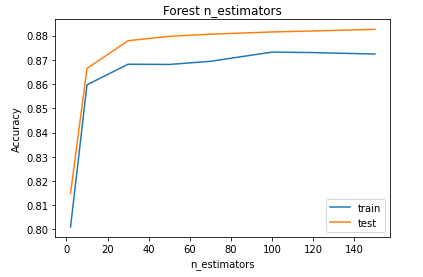

Error is the least around 100 n_estimators:
* n_estimates:  2   Mean Absolute Error: 22695.97
Forest Score:  0.801 || 0.8149 cross validate.
* n_estimates:  10   Mean Absolute Error: 18189.29
Forest Score:  0.8597 || 0.8665 cross validate.
* n_estimates:  30   Mean Absolute Error: 17384.96
Forest Score:  0.8682 || 0.8779 cross validate.
* n_estimates:  50   Mean Absolute Error: 17406.8
Forest Score:  0.8681 || 0.8797 cross validate.
* n_estimates:  70   Mean Absolute Error: 17308.51
Forest Score:  0.8694 || 0.8806 cross validate.
* n_estimates:  100   Mean Absolute Error: 17106.17
Forest Score:  0.8732 || 0.8815 cross validate.
* n_estimates:  120   Mean Absolute Error: 17101.13
Forest Score:  0.873 || 0.8819 cross validate.
* n_estimates:  150   Mean Absolute Error: 17124.59
Forest Score:  0.8724 || 0.8826 cross validate.

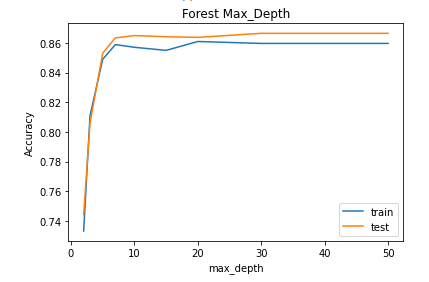


In [23]:
from sklearn.ensemble import RandomForestRegressor

#Check for Error and find Best n_estimators:
def forestNumEst():
    nList=[2, 10, 30, 50, 70, 100, 120, 150]
    
    dMAE={} #dictionary of n_estimators as key and MAE as value:
    dMSE={} #dictionary of n_estimators as key and MSE as value:
    
    nEst=[] #store n_estimators
    cvList=[] #cross validate list
    accList=[] #accuracy train data
    maeList=[] #error
    mseList=[] #square error
    cvMseList=[]
    
    for n in nList:
        forest = RandomForestRegressor(n_estimators=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        MSE = np.square(np.subtract(y_test,y_pred)).mean()
        dMAE[n]=MAE
        dMSE[n]=MSE
      
        #CROSS VALIDATE TEST RESULTS:
        forestScore = forest.score(X_test, y_test).round(4)  # train test 
        forestCV = cross_validate(forest, X, y, cv = 5, scoring= 'r2')
        forestCV=forestCV['test_score'].mean().round(4)
        
        print("n_estimates: ", n,  '  Mean Absolute Error:', MAE)
        print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")
       
        cvList.append(forestCV)
        accList.append(forestScore)
        maeList.append(MAE)
        mseList.append(MSE)
        
    plt.plot(nList,accList, label="train")
    plt.plot(nList,cvList, label="test")
    plt.title("Forest n_estimators")
    plt.xlabel('n_estimators')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 
    
    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)
    print(dMSE)
    
def ForestDepth():
    nList=[2, 3, 5, 7, 10, 15, 20, 30, 40, 50]
    dMAE={} #dictionary of n_estimators as key and MSE as value:
    nEst=[] #store n_estimators
    cvList=[] #cross validate list
    accList=[] #accuracy train data
    mae=[] #error
    
    for n in nList:
        forest = RandomForestRegressor(n_estimators=10, max_depth=n, random_state = 0)
        forest.fit(X_train, y_train)
        y_pred = forest.predict(X_test)
        MAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
        dMAE[n]=MAE
      
        #CROSS VALIDATE TEST RESULTS:
        forestScore = forest.score(X_test, y_test).round(4)  # train test 
        forestCV = cross_validate(forest, X, y, cv = 5, scoring= 'r2')
        forestCV=forestCV['test_score'].mean().round(4)
     
        print("max_depth: ", n,  '  Mean Absolute Error:', MAE)
        print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")
       
        nEst.append(n)
        cvList.append(forestCV)
        accList.append(forestScore)
        mae.append(MAE)
        
    plt.plot(nList,accList, label="train")
    plt.plot(nList,cvList, label="test")
    plt.title("Forest Max_Depth")
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 
    
    dMAE=sorted(((v, k) for k, v in dMAE.items()), reverse=False)

#forestNumEst() 
#ForestDepth()

### Forest Final Prediction

In [24]:
num=100
f_max_depth=20
forest = RandomForestRegressor(n_estimators=num, max_depth=f_max_depth, random_state = 0)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

#Print Metrics:
forestR2 = r2_score(y_test, y_pred).round(4)  
forestMAE=metrics.mean_absolute_error(y_test, y_pred).round(2)
print("Forest r2: ", forestR2, " ||  MAE: ", forestMAE)

#CROSS VALIDATE TEST RESULTS:
forestScore = forest.score(X_test, y_test).round(4)  # train test 
forestCV = cross_validate(forest, X, y, cv = 5, scoring= 'r2')
forestCV=forestCV['test_score'].mean().round(4)
print("Forest Score: ", forestScore  ,"||" , forestCV, "cross validate.")

#forest_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
#print("Forest AUC: ", forest_auc)

Forest r2:  0.8875  ||  MAE:  15596.12
Forest Score:  0.8875 || 0.8773 cross validate.


# K-Nearest Neighbors (KNN)
First, we must select the optimal K value with the least amount of error. Because the large amount of data, the KNN model runs very slow which is a big issue for KNN. If you do run the KNN model, after some time, the final metrics show the following results:

In [25]:
from sklearn.neighbors import KNeighborsClassifier

def knnError():
    print("Selecting an optimal K value:")
    error_rates = []
    for i in range(1, 10, 2): #Must be an odd number to break a tie
        new_model = KNeighborsClassifier(n_neighbors = i)
        new_model.fit(X_train, y_train)
        new_predictions = new_model.predict(X_test)
        error_rates.append(np.mean(new_predictions != y_test))
    plt.figure(figsize=(16,12))
    plt.plot(error_rates)

def knnModel():
    #Train the model and make predictions:
    knn = KNeighborsClassifier(n_neighbors =3) 
    knn.fit(X_train, y_train)
    knnPredict = knn.predict_proba(X_test)[::,1]

    #calculate AUC of model
    knn_auc = round( metrics.roc_auc_score(y_test, knnPredict), 4 ) 
    print("Knn AUC: ", knn_auc)

def knnReports():
    acc = metrics.accuracy_score(y_test_data, knnPredict)
    print(confusion_matrix(y_test, knnPredict))
    print(classification_report(y_test, knnPredict))
    print(confusion_matrix(y_test, knnPredict))

# Decision Tree
* The decision tree r-squared provides high results overall as a model. 
* The highest r-squared is by using max_depth = 3. However, this provides high error and bad score. 
* Using max_depth = 5 and max_leaf_nodes =25 provides high r-squared and low error.
* The best max_depth dictionary with error as a value is 10: <br>
{2: 36106.9895, 3: 31746.944, 5: 29228.6968, 7: 30077.7522, 9: 29128.2362, 10: 29095.3825, 12: 29095.3825}

#### Tree Overfitting:
Decision tree tends to overfit data which is clearly happening in this case:
* Decision Tree r-squared is: 0.9816
* Tree Score:  0.9816
* 0.7314  Decision Tree cross validate.

Line graphs should help show where the decision tree parameters should truly be set at. The train data results should correlated with the final test data. 

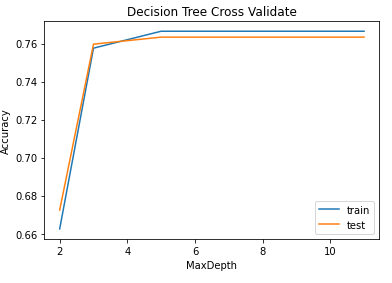

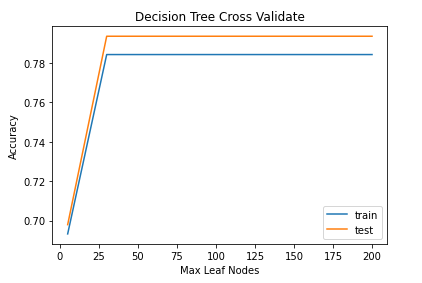

In [26]:
from sklearn.tree import DecisionTreeRegressor

#FIND best_tree_size LEAF NODES:
def calcLeaf():
    candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
    maeDic={} #dictionary  key=leaf  mae=value
    for leaf in candidate_max_leaf_nodes:
        model = DecisionTreeRegressor(max_leaf_nodes=leaf, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[leaf]=mae
    print(maeDic)
    best_tree_size = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_tree_size)
    
def calcDepth():
    max_depth_list = [2, 3, 5, 7, 9, 10, 12]
    maeDic={} #dictionary  key=depth  mae=value
    for d in max_depth_list:
        model = DecisionTreeRegressor(max_leaf_nodes=100, max_depth=d, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        maeDic[d]=mae
    print(maeDic)
    best_max_depth = sorted(maeDic, key=lambda x : maeDic[x])[0]
    print(best_max_depth, " best max_depth with least error.") #10
    
def automateTree():
    start=time.time()
    candidate_max_leaf_nodes = [5, 50, 100, 250, 500]
    max_depth_list = [2, 3, 5, 7, 9, 11]
    
    #STORE DATA INTO LISTS FOR DATAFRAME LATER:
    aucList=[]
    maeList=[]
    maxDepthList=[]
    maxLeafNodesList=[]

    for d in max_depth_list:
        for leaf in candidate_max_leaf_nodes:
            model = DecisionTreeRegressor(max_leaf_nodes=leaf, max_depth=d, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae = mean_absolute_error(y_test, y_pred).round(4)
            treeR2 = r2_score(y_test, y_pred).round(4)
            
            aucList.append(treeR2)
            maeList.append(mae)
            maxDepthList.append(d)
            maxLeafNodesList.append(leaf)
           
    df = pd.DataFrame(list(zip(aucList, maeList, maxDepthList, maxLeafNodesList)),
                          columns=['AUC','MAE', 'MaxDepth', 'MaxLeafNodes'])
    
    df=df.sort_values(by=['MAE'], ascending=False)
    return df
   
#calcDepth()
#calcLeaf()
#treeDF=automateTree()    
#treeDF.head(50)

In [27]:
def validateDepthTree():
    max_depth_list = [2, 3, 5, 7, 9, 11]
    
    accList=[]
    cvList=[]
    maeList=[]
    maxLeafNodesList=[]
    maxDepthList=[]

    for d in max_depth_list:
        maxDepthList.append(d)
        
        tree = DecisionTreeRegressor(max_leaf_nodes=10, max_depth=d, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeR2 = r2_score(y_test, y_pred).round(4)
        accList.append(treeR2)

        #CROSS VALIDATE TEST RESULTS:
        treeScore = tree.score(X_test, y_test).round(4)  # train test 
        #print("Tree Score: ", treeScore)
        treeCV = cross_validate(tree, X, y, cv = 5, scoring= 'r2')
        treeCV=treeCV['test_score'].mean().round(4)
        cvList.append(treeCV)
        #print(treeCV, " Decision Tree cross validate.")
       # print(treeCV-treeR2, " validation error")
    plt.plot(maxDepthList,accList, label="train")
    plt.plot(maxDepthList,cvList, label="test")
    plt.title('Decision Tree Cross Validate')
    plt.xlabel('MaxDepth')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show() 
#validateDepthTree()

In [28]:
def leafTree():
    accList=[]
    cvList=[]
    maeList=[]
    
    maxLeafNodesList=[]
    maxDepthList=[]
    
    candidate_max_leaf_nodes = [5, 30, 50, 80, 100, 200]
    for leaf in candidate_max_leaf_nodes:
        maxLeafNodesList.append(leaf)
        
        tree = DecisionTreeRegressor(max_leaf_nodes=leaf, max_depth=4, random_state=42)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred).round(4)
        treeR2 = r2_score(y_test, y_pred).round(4)

        #CROSS VALIDATE TEST RESULTS:
        treeScore = tree.score(X_test, y_test).round(4)  # train test 
        treeCV = cross_validate(tree, X, y, cv = 5, scoring= 'r2')
        treeCV=treeCV['test_score'].mean().round(4)
        cvList.append(treeCV)
        accList.append(treeR2)

    plt.plot(maxLeafNodesList,accList, label="train")
    plt.plot(maxLeafNodesList,cvList, label="test")
    plt.title('Decision Tree Cross Validate')
    plt.xlabel('Max Leaf Nodes')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#leafTree()

#### Final Decision Tree Prediction
Input best_tree_size and best_depth from above functions. 
High accuracy does not equal high score. Best scores seem to take account error as well into account.

In [29]:
best_tree_size=50
best_depth=4

tree = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, 
                             max_depth=best_depth, random_state=42)
tree.fit(X, y)
y_pred = tree.predict(X_test)

#AUC and r2 metric
tree_r2 = r2_score(y_test, y_pred).round(4)
print("Decision Tree r-squared is:", tree_r2)

#CROSS VALIDATE TEST RESULTS:
treeScore = tree.score(X_test, y_test).round(4)  # train test 
print("Tree Score: ", treeScore)
treeCV = cross_validate(tree, X, y, cv = 5, scoring= 'r2')
treeCV=treeCV['test_score'].mean().round(4)
print(treeCV, " Decision Tree cross validate.")

def printReports(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    #tree_auc = round( metrics.roc_auc_score(y_test, y_pred), 4 ) 
    #print("AUC for decision tree is: ", tree_auc)

Decision Tree r-squared is: 0.84
Tree Score:  0.84
0.7882  Decision Tree cross validate.


# Support Vector 
SVM r_squared is 0.4196. With a large number of samples, SVM is extremely slow. In this model, SVM is slow and should consider not being used.

#### GridSearch Tune
The best SVM parameters:
{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=0.1, gamma=1)

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def tuneSVM():
    # defining parameter range
    param_grid = {'C': [0.1, 1, 10, 100, 1000],
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf']}

    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

    # fitting the model for grid search
    grid.fit(X_train, y_train)

    # print best parameter after tuning
    print(grid.best_params_)

    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)
#tuneSVM()

In [31]:
def runSVM():
    svm=SVC(C=0.1, gamma=1, kernel = 'rbf')
    svm.fit(X_train, y_train)
    svmPedict = svm.predict(X_test)

    svmR2 = r2_score(y_test, svmPedict).round(4) 
    print("SVM r2: ", svmR2) 

    svmMAE=metrics.mean_absolute_error(y_test, svmPedict)

# Test Data Section
First, we will display the test data. As we can see there is no SalesPrice prediction at the end. This is what we will be predicting. 

In [32]:
testDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Match Test Columns with Trained

In [33]:
features = list(X.columns.values)
testDF['TotalSF'] = testDF['TotalBsmtSF'] + testDF['1stFlrSF'] + testDF['2ndFlrSF'].drop(columns=['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])
testDF['SaleCondition']=testDF['SaleCondition'].apply(lambda x:1 if x == 'Normal' else 0)
testDF['Fence']=testDF['Fence'].fillna(0).apply(lambda x:0 if x == 0 else 1)
testDF['Street']=testDF['Street'].fillna(0).apply(lambda x:0 if x =='Grvl' else 1)
testDF['CentralAir'] = testDF['CentralAir'].replace({'Y':0, 'N':1})
testDF['MiscFeature']=testDF['MiscFeature'].apply(lambda x:0 if x == 0 else 1)
testDF['HeatingQC']=testDF['HeatingQC'].apply(lambda x:1 if x == 'Ex' else 0)
testDF['Condition1']=testDF['Condition1'].apply(lambda x:1 if x == 'Norm' else 0)
testDF['Condition2']=testDF['Condition2'].apply(lambda x:1 if x == 'Norm' else 0)
testDF['GarageFinish']=testDF['GarageFinish'].apply(lambda x:0 if x == 'Unf' else 1)
testDF=testDF[features]

#Fill Missing Values:
testDF= testDF.fillna(testDF.mean())
print(testDF.shape)
testDF.head()

(1459, 44)


,Id,MSSubClass,LotFrontage,LotArea,Street,Condition1,Condition2,OverallQual,OverallCond,YearBuilt,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleCondition,TotalSF
0,1461,20,80.0,11622,1,0,1,5,6,1961,...,0,120,0,1,1,0,6,2010,1,1778.0
1,1462,20,81.0,14267,1,1,1,6,6,1958,...,0,0,0,0,1,12500,6,2010,1,2658.0
2,1463,60,74.0,13830,1,1,1,5,5,1997,...,0,0,0,1,1,0,3,2010,1,2557.0
3,1464,60,78.0,9978,1,1,1,6,6,1998,...,0,0,0,0,1,0,6,2010,1,2530.0
4,1465,120,43.0,5005,1,1,1,8,5,1992,...,0,144,0,0,1,0,1,2010,1,2560.0


# Final Prediction 

In [34]:
test_predictions = forest.predict(testDF).round(2)
output = pd.DataFrame({'Id': testDF['Id'], 'SalePrice': test_predictions}).sort_values(by='Id').reset_index(drop=True)
print(output.shape) #(1459, 2)
output.head()

(1459, 2)


,Id,SalePrice
0,1461,127396.00
1,1462,165530.40
2,1463,190811.66
3,1464,186749.01
4,1465,191705.72


In [35]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
